In [5]:
import numpy as np
import glob
import re

from aicsimageio import AICSImage, readers
from pathlib import Path
from matplotlib import pyplot as plt

from blimp.preprocessing.illumination_correction import IlluminationCorrection

# Correct illumination

Search images of the correct channel in the input directories

In [6]:
images_dir_1 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240315/240314_ARMC5KO_PolyA/20240315_142116_487/OME-TIFF-MIP/")
#images_dir_2 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240307/240304_ARMC5KO_EU/20240307_184329_444/OME-TIFF-MIP/")
#images_dir_3 = Path("/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240229/240226_ARMC5KO_EU/20240229_172045_717/OME-TIFF-MIP/")
image_files_1 = glob.glob(str(images_dir_1 / "*.tiff"))
#image_files_2 = glob.glob(str(images_dir_2 / "*.tiff"))
#image_files_3 = glob.glob(str(images_dir_3 / "*.tiff"))

Bright dust in images can be detrimental for calculation of a standard deviation for illumination correction. We check that all images are within the same intensity range

In [7]:
def find_outlier_indices(image_files):
    percentiles = np.stack(
        [[np.percentile(a=AICSImage(image_file,reader=readers.ome_tiff_reader.OmeTiffReader).get_image_data('YX',C=c),q=[90,95]) for c in range(4)] for image_file in image_files]
    )
    percentiles_95 = percentiles[:,:,1]
    percentiles_95_p25 = np.percentile(percentiles_95,25,axis=0)
    percentiles_95_p75 = np.percentile(percentiles_95,75,axis=0)
    percentiles_95_iqr = percentiles_95_p75 - percentiles_95_p25
    upper_limit = percentiles_95_p75 + 1.5*percentiles_95_iqr
    outlier = percentiles_95 > upper_limit
    outlier_indices = np.argwhere(outlier[:,0:2])[:,0]
    return outlier_indices, percentiles

In [8]:
%%time
outlier_indices_1, percentiles_1 = find_outlier_indices(image_files_1)
reference_image_files_1 = np.delete(image_files_1,outlier_indices_1)

CPU times: user 4min 10s, sys: 16.5 s, total: 4min 27s
Wall time: 8min 13s


In [14]:
#%%time
#outlier_indices_2, percentiles_2 = find_outlier_indices(image_files_2)
#reference_image_files_2 = np.delete(image_files_2,outlier_indices_2)

In [15]:
#%%time
#outlier_indices_3, percentiles_3 = find_outlier_indices(image_files_3)
#reference_image_files_3 = np.delete(image_files_3,outlier_indices_3)

In [16]:
image_files = image_files_1 #+ image_files_2 + image_files_3
reference_image_files = reference_image_files_1.tolist() #+ reference_image_files_2.tolist() + reference_image_files_3.tolist()

In [17]:
len(image_files)

288

In [18]:
len(reference_image_files)

288

Fit a ``blimp.IlluminationCorrection`` object

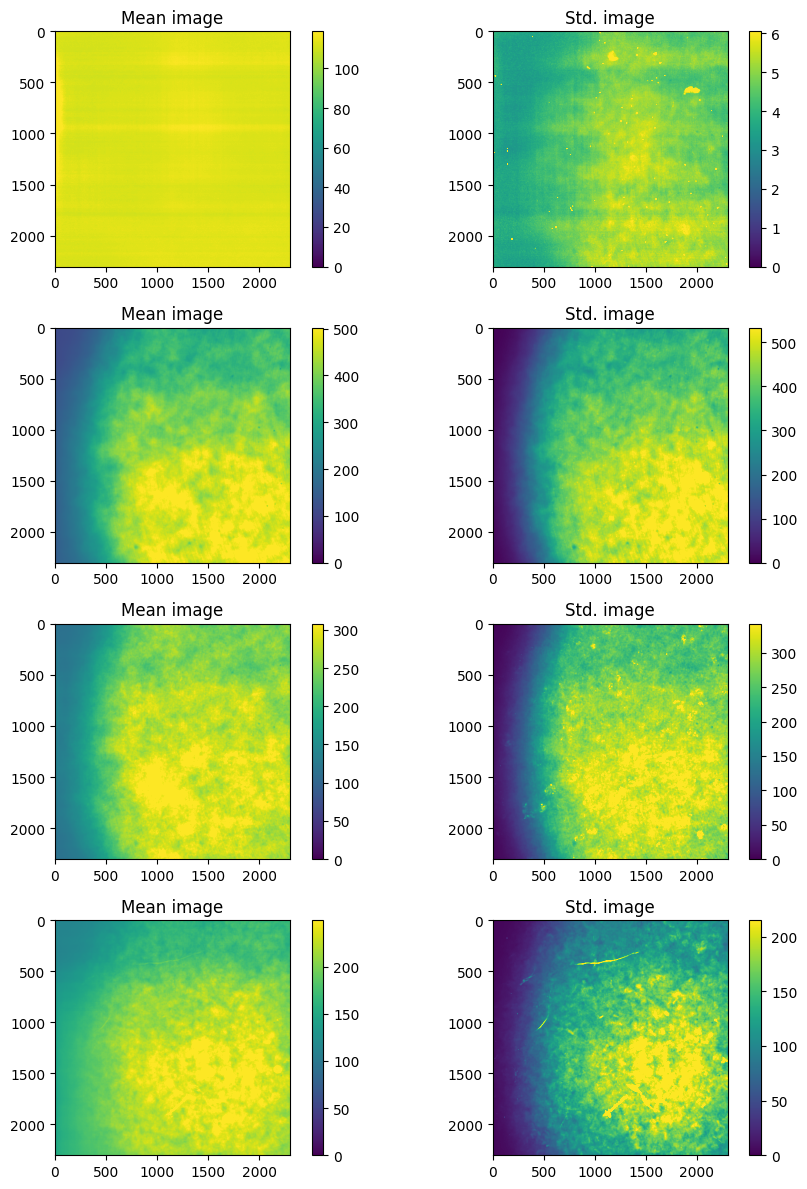

In [19]:
illumination_correction = IlluminationCorrection(
    reference_images=reference_image_files,
    timelapse=False,
)
illumination_correction.plot()

# Save illumination correction object to disk

The ``blimp.IlluminationCorrection`` object can be persisted on disk to be later applied when analysing images

In [20]:
illumcorr_filename = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240315/240314_ARMC5KO_PolyA/ILLUMCORR/illumination_correction.pkl"

In [21]:
illumination_correction.save(Path(illumcorr_filename))

# Check results

IlluminationCorrection can be applied using the ``correct()`` method of the ``blimp.IlluminationCorrection`` object

In [22]:
illumination_correction = IlluminationCorrection(from_file=illumcorr_filename)

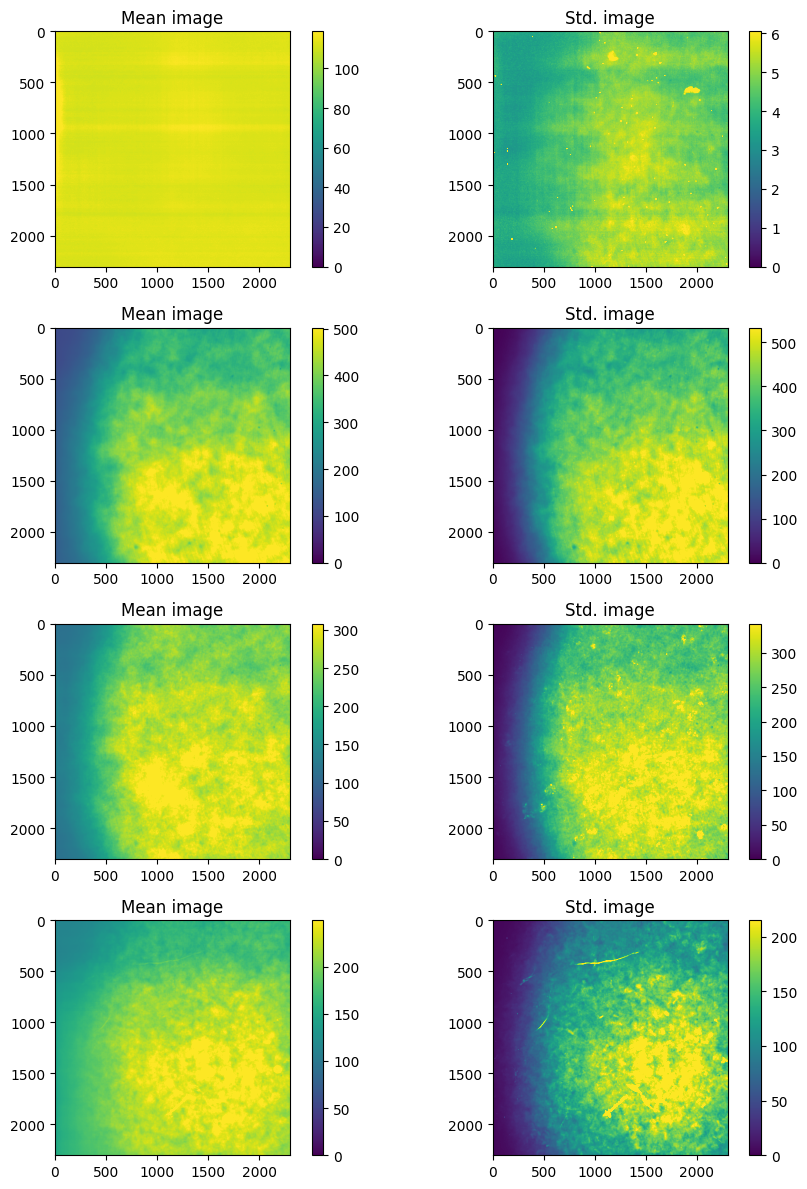

In [23]:
illumination_correction.plot()

In [25]:
raw = AICSImage(image_files[50], reader=readers.ome_tiff_reader.OmeTiffReader)
corrected = illumination_correction.correct(raw)

In [26]:
#illumination_correction.mean_image.get_image_data("YX", C=1, Z=0, T=0)
illumination_correction.mean_mean_image

[113.01371129615484, 370.4952311967136, 246.66177244801253, 199.23614227886242]

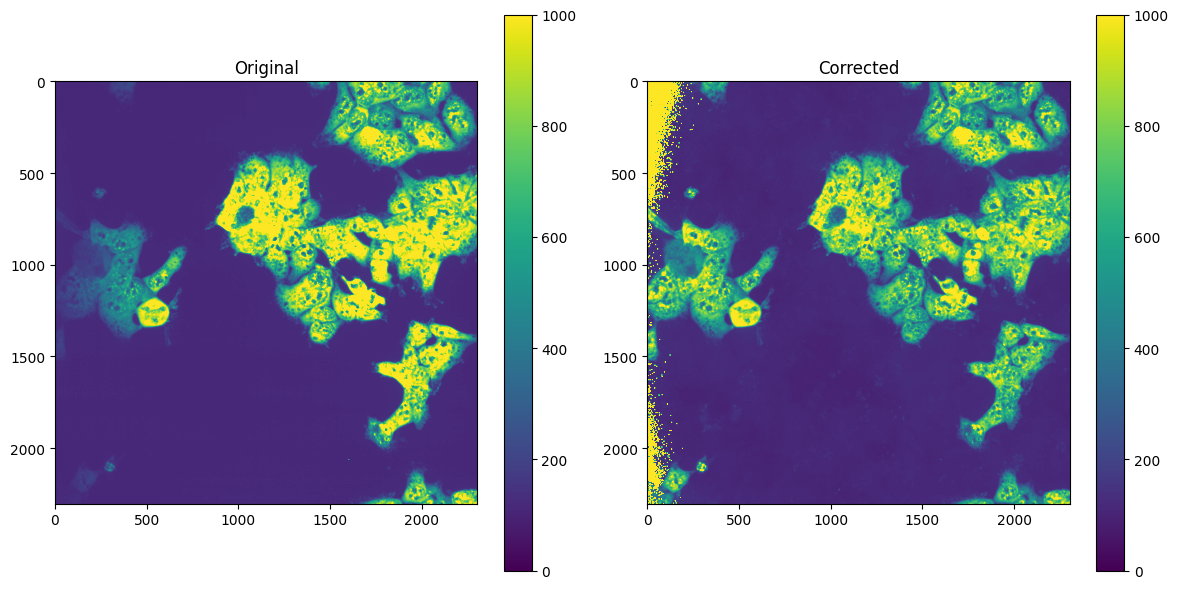

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im = axes[0].imshow(raw.get_image_data('YX',C=2,T=0), vmin=0, vmax=1000)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(corrected.get_image_data('YX',C=2,T=0), vmin=0, vmax=1000)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

Will have to crop part of these images (from say 500: on the X-axis)

In [31]:
raw.channel_names

['None', '488', '647', '405']